<a href="https://colab.research.google.com/github/Priyanshi965/face-mask-detection-tensorflow/blob/main/Object_detection_using_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import zipfile, os
zip_path = '/content/drive/MyDrive/Face-Mask-Detection.zip'
destination_path = '/content/Face-Mask-Detection/'

os.makedirs(destination_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(destination_path)
print(f"Successfully unzipped {zip_path} to {destination_path}")

Successfully unzipped /content/drive/MyDrive/Face-Mask-Detection.zip to /content/Face-Mask-Detection/


In [7]:
import os
import glob

dataset_path = '/content/Face-Mask-Detection/'


image_extensions = ['*.jpg', '*.jpeg', '*.png']

print(os.listdir(dataset_path))

image_files = []

for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(dataset_path, 'images', ext)))

print(f"\nNumber of image files: {len(image_files)}")


annotation_files = glob.glob(os.path.join(dataset_path, 'annotations', '*.xml'))
print(f"Number of annotation files: {len(annotation_files)}")

print("\nSample image files:")
for i in range(min(5, len(image_files))):
    print(image_files[i])

print("\nSample annotation files:")
for i in range(min(5, len(annotation_files))):
    print(annotation_files[i])

['images', 'annotations']

Number of image files: 853
Number of annotation files: 853

Sample image files:
/content/Face-Mask-Detection/images/maksssksksss571.png
/content/Face-Mask-Detection/images/maksssksksss522.png
/content/Face-Mask-Detection/images/maksssksksss468.png
/content/Face-Mask-Detection/images/maksssksksss703.png
/content/Face-Mask-Detection/images/maksssksksss779.png

Sample annotation files:
/content/Face-Mask-Detection/annotations/maksssksksss518.xml
/content/Face-Mask-Detection/annotations/maksssksksss642.xml
/content/Face-Mask-Detection/annotations/maksssksksss577.xml
/content/Face-Mask-Detection/annotations/maksssksksss640.xml
/content/Face-Mask-Detection/annotations/maksssksksss721.xml


In [8]:
!pip install tensorflow==2.19.0
!pip install tf_slim
!pip install lxml
!pip install pycocotools
!pip install object_detection


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.5 MB/s eta 0:00:00


In [10]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
import glob

dataset_path = '/content/Face-Mask-Detection/'

def xml_to_csv(path):
    """
    Iterates through all .xml files in a directory and combines them into a single Pandas DataFrame.
    Args:
        path: String containing path to the annotations directory.
    Returns:
        Pandas DataFrame which contains the following columns: filename, width, height, class, xmin, ymax, xmax, ymin.
    """
    xml_list = []
    for xml_file in glob.glob(os.path.join(path, '*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (
                root.find('filename').text,
                int(root.find('size/width').text),
                int(root.find('size/height').text),
                member.find('name').text,
                int(member.find('bndbox/xmin').text),
                int(member.find('bndbox/ymin').text),
                int(member.find('bndbox/xmax').text),
                int(member.find('bndbox/ymax').text)
            )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

annotations_path = os.path.join(dataset_path, 'annotations')
xml_df = xml_to_csv(annotations_path)
print(f"Successfully converted XML annotations to DataFrame. Found {len(xml_df)} annotations.")

Successfully converted XML annotations to DataFrame. Found 4072 annotations.


In [12]:
annotations_path = os.path.join(dataset_path, 'annotations')
xml_df = xml_to_csv(annotations_path)
print(f"Successfully converted XML annotations to DataFrame. Found {len(xml_df)} annotations.")

display(xml_df.head())



Successfully converted XML annotations to DataFrame. Found 4072 annotations.


,filename,width,height,class,xmin,ymin,xmax,ymax
0,maksssksksss518.png,400,225,with_mask,3,112,12,122
1,maksssksksss518.png,400,225,with_mask,27,178,35,186
2,maksssksksss518.png,400,225,with_mask,25,107,35,117
3,maksssksksss518.png,400,225,with_mask,51,108,61,120
4,maksssksksss518.png,400,225,without_mask,43,137,53,148


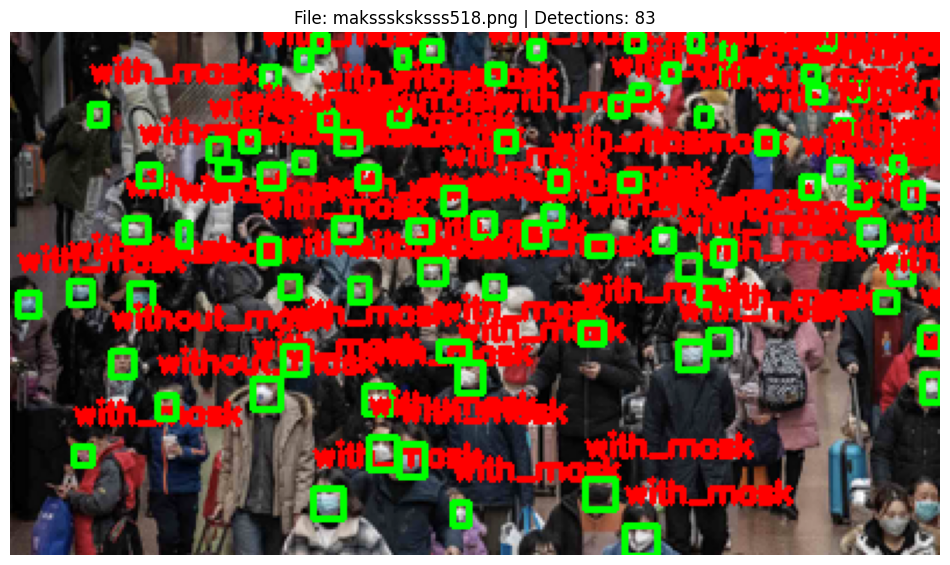

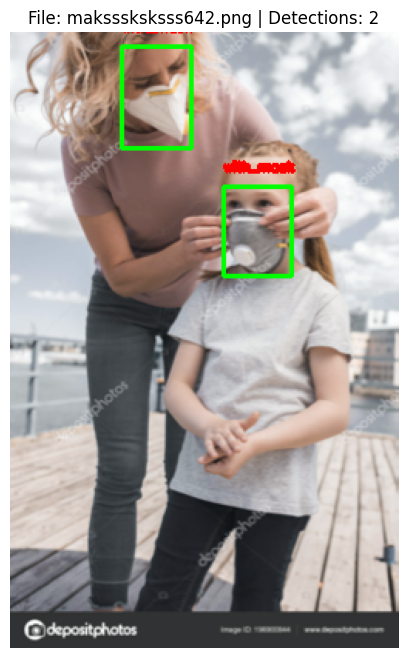

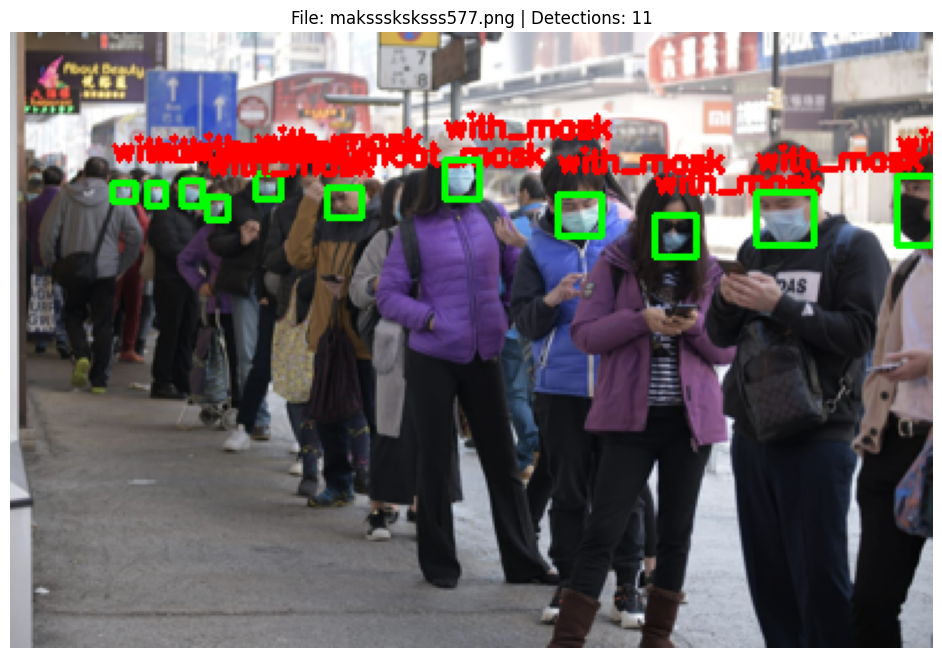

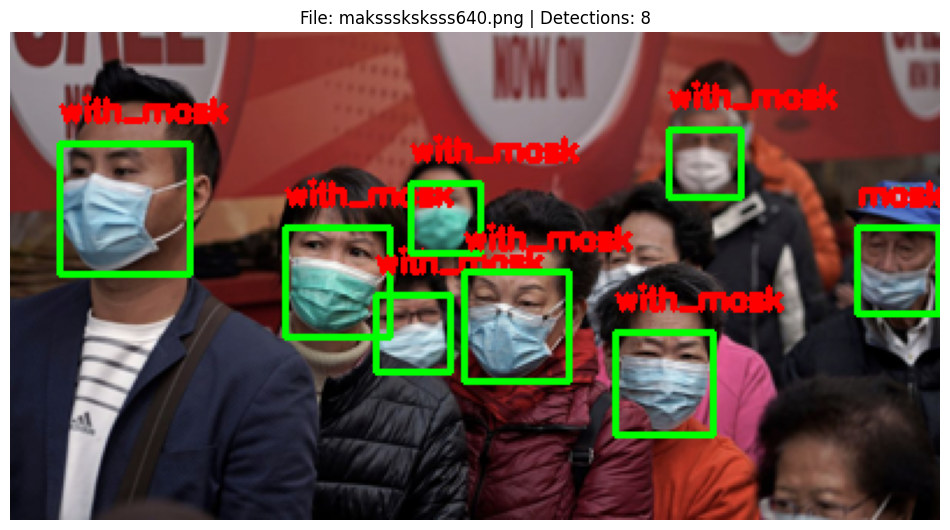

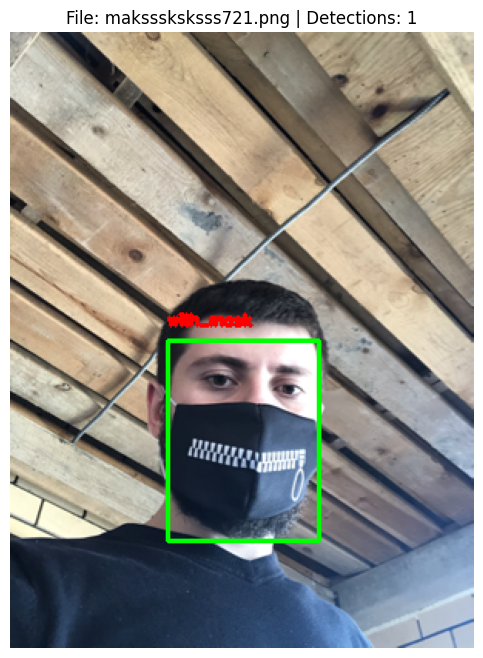

In [9]:
import cv2
import matplotlib.pyplot as plt
import os

dataset_path = '/content/Face-Mask-Detection/'
images_path = os.path.join(dataset_path, 'images')

def display_readable_images(df, num_samples=5):
    unique_images = df['filename'].unique()[:num_samples]

    for filename in unique_images:
        img_path = os.path.join(images_path, filename)
        image = cv2.imread(img_path)

        if image is None:
            print(f"Could not find or read: {filename}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        relevant_annotations = df[df['filename'] == filename]

        h, w, _ = image.shape
        thickness = max(2, int(w / 400))
        font_scale = w / 900

        for _, row in relevant_annotations.iterrows():
            cv2.rectangle(image, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), thickness)
            cv2.putText(image, row['class'], (row['xmin'], row['ymin'] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), thickness)

        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.title(f"File: {filename} | Detections: {len(relevant_annotations)}")
        plt.axis('off')
        plt.show()

display_readable_images(xml_df, num_samples=5)